# Analyze Region 2 - Western Canada and USA

This notebook analyzes the largest glaciers in Region 2 - Western Canada and USA

Notes:
* GLIMS has its 3rd largest glacier as Jewakwa (131.1 km2) but RGI has its third largest glacier as RGI60-02.03578 (136.85) which is not Jewakwa but right next to it. What is that glacier in RGI? After searching google and google scholar, I found no information about this the glacier that is in RGI. Once the anwser is known if I should use that RGI glacier will need to do some code modifications to include only the glaciers needed in the shapefile. Changes will need to be made under the "Creat Final Dataframe" section.
* Primeclass isn't set in the GLIMS database for any of these glaciers. Need to determine one. Perhaps 6 - mountain glacier?
* Jewakwa is on Homathko Icefield (https://pbase.com/nolock/homathko)
* Klinaklini Glacier is on  Ha-litzuk Icefield
* The GLIMS ID for Heakamie glacier is from the RGI database

In [1]:
import os
import os.path as op
import sys
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.patches import Patch
import geopandas as gpd
from shapely.geometry import Polygon
import rasterio as rio
from rasterio.plot import plotting_extent
from earthpy import clip as cl
import earthpy.plot as ep

# set working dir
HOME = op.join(op.expanduser("~"))
os.chdir(os.path.join(HOME, "git/wgms-glacier-project"))

# Set up path to load scripts
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)
    
import scripts.wgms_scripts as ws

# Set Up Region Info

In [2]:
# Set region number, region name, and region index
# Once these are set, this notebook should run automatically for the specified region
region_number = "2"
region_name = "Western Canada and USA"

# The variable primeclass needs to be updated with the primary class of the ice complexes for the region
# This may need to be a list in some instances
# 2: icefield, 3: ice cap, 4: outlet glacier, 5: valley glacier, 6: mountain glacier
primeclass = 5 # Michael suggests valley glacier

# Note for the region index, region_index_1 should be one less than the region number and 
# region_index_2 should be equal to the region number. For example, for region 1, index_1 should be set to 0 and 
# index_2 should be set to 1
region_index_1 = 1
region_index_2 = 2

# Show Region

In [3]:
# Open natural earth basemap TIF file
ne_fp = 'data/natural-earth/NE1_HR_LC_SR_W/NE1_HR_LC_SR_W.tif' # 10 m res
with rio.open(ne_fp) as ne_src:
    # Convert / read the data into a numpy array:
    ne_raster = ne_src.read()
    ne_src_extent = plotting_extent(ne_src)
    bounds = ne_src.bounds
    ne_raster_meta = ne_src.meta

In [4]:
# Open glacier regions
glacier_regions_fp = "data/gtn-g-glacier-regions/cleaned/GTN-G_glacier_regions_201707_cleaned.shp"
glacier_regions = gpd.read_file(glacier_regions_fp)

# Extract Region outline
region_outline = glacier_regions[region_index_1:region_index_2]

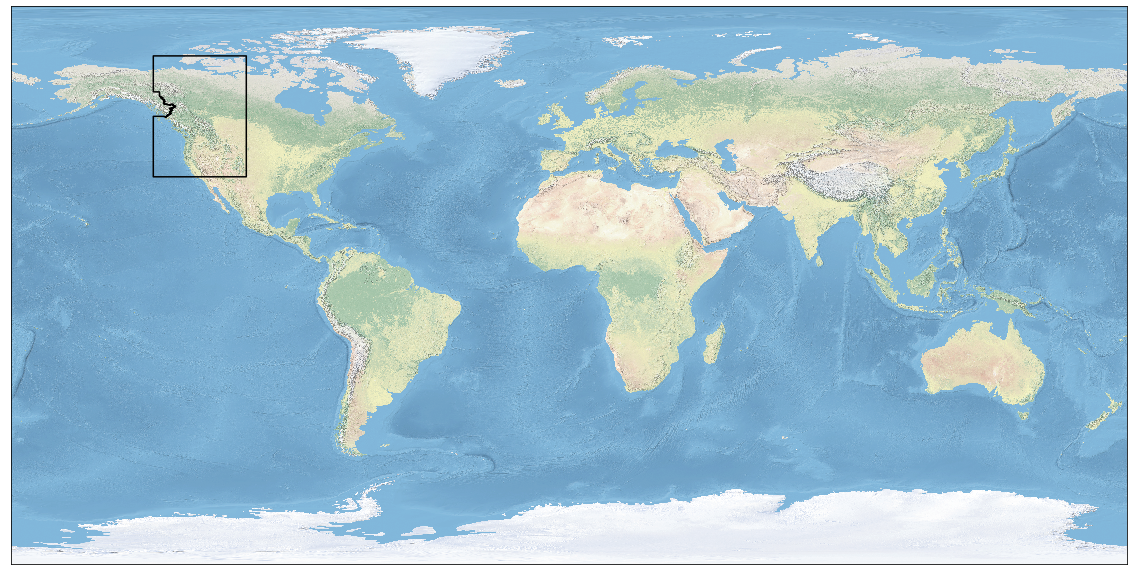

In [5]:
# Plot region outline over the natural earth
# Plot natural earth basemap
fig, ax = plt.subplots(figsize=(20, 20))

# Plot natural earth
ep.plot_rgb(ne_raster,
            rgb=[0, 1, 2],
            extent=ne_src_extent,
            ax=ax)

# Plot region outline
region_outline.boundary.plot(ax=ax, color="black")

plt.show()

In [6]:
region_outline.bounds

,minx,miny,maxx,maxy
1,-134.001734,35.0,-104.0,74.0


# Glaciers

## Open GLIMS 3 Largest Glaciers Data

In [7]:
# Open GLIMS three largest glacier outlines for this region.
glims_glaciers_fn = "data/glims/processed/largest/glims_region_" + region_number + "_largest.shp"
glims_glaciers_df = gpd.read_file(glims_glaciers_fn)

In [8]:
# Check if GLIMS glacier names are of the "NoneType" because can't print legends and such if they are
# If they are, set them to a string "NONE"
glims_df_len = len(glims_glaciers_df)
for x in range(glims_df_len):
    if glims_glaciers_df['glac_name'][x] == None:
        print("GLIMS glacier " + str(x) + " equals none")
        glims_glaciers_df.loc[x, 'glac_name'] = 'NONE'

In [9]:
glims_glaciers_df

,region_no,glac_id,area,db_area,width,length,primeclass,min_elev,mean_elev,max_elev,src_date,glac_name,geometry
0,2,G234082E51540N,469.80,469.7660,0.0,0.0,0.0,0.0,0.0,0.0,2004-07-22T00:00:00,Klinaklini Glacier,"POLYGON Z ((-125.771121 51.61014 0, -125.77210..."
1,2,G234658E51318N,153.40,153.4270,0.0,0.0,0.0,0.0,0.0,0.0,2004-07-22T00:00:00,Franklin Glacier,"POLYGON Z ((-125.228529 51.310758 0, -125.2275..."
2,2,G235401E51143N,131.10,131.1120,0.0,0.0,0.0,0.0,0.0,0.0,2004-08-09T00:00:00,Jewakwa Glacier,"POLYGON Z ((-124.539706 51.17575 0, -124.53989..."
3,2,G236376E50799N,81.98,81.9767,0.0,0.0,0.0,0.0,0.0,0.0,2004-08-09T00:00:00,Bridge Glacier,"POLYGON Z ((-123.674076 50.877699 0, -123.6729..."
4,2,G233819E52013N,73.25,73.2519,0.0,0.0,0.0,0.0,0.0,0.0,2004-07-22T00:00:00,Jacobsen Glacier,"POLYGON Z ((-126.101022 52.059191 0, -126.0987..."


## Open RGI 3 Largest Glaciers Data

In [10]:
# Open RGI three largest glacier outlines for this region.
rgi_glaciers_fn = "data/rgi/processed/largest/rgi_region_" + region_number + "_largest.shp"
rgi_glaciers_df = gpd.read_file(rgi_glaciers_fn)

In [11]:
# Check if RGI glacier names are of the "NoneType" because can't print legends and such if they are
# If they are, set them to a string "NONE"
rgi_df_len = len(rgi_glaciers_df)
for x in range(rgi_df_len):
    if rgi_glaciers_df['Name'][x] == None:
        print("RGI glacier " + str(x) + " equals none")
        rgi_glaciers_df.loc[x, 'Name'] = 'NONE'

RGI glacier 0 equals none
RGI glacier 1 equals none
RGI glacier 2 equals none
RGI glacier 3 equals none
RGI glacier 4 equals none


In [12]:
rgi_glaciers_df

,RGIId,GLIMSId,BgnDate,EndDate,CenLon,CenLat,O1Region,O2Region,Area,Zmin,...,Aspect,Lmax,Status,Connect,Form,TermType,Surging,Linkages,Name,geometry
0,RGI60-02.05157,G234050E51502N,20049999,20069999,-125.950,51.5024,2,2,469.766,146,...,122,43272,0,0,0,0,0,9,NONE,"POLYGON ((-125.853488 51.64645400000006, -125...."
1,RGI60-02.12428,G234663E51321N,20049999,20069999,-125.337,51.3210,2,2,153.427,587,...,234,26870,0,0,0,0,0,9,NONE,"POLYGON ((-125.34191 51.40133500000007, -125.3..."
2,RGI60-02.03578,G235390E51067N,20049999,20069999,-124.610,51.0666,2,2,136.850,589,...,283,23803,0,0,0,0,0,9,NONE,"POLYGON ((-124.648724 51.11781500000006, -124...."
3,RGI60-02.03586,G235376E51153N,20049999,20069999,-124.624,51.1525,2,2,131.112,697,...,276,23254,0,0,0,0,0,9,NONE,POLYGON ((-124.6618999999999 51.21381400000007...
4,RGI60-02.02636,G236361E50822N,20049999,20069999,-123.639,50.8216,2,2,81.977,1388,...,90,18576,0,0,0,0,0,9,NONE,POLYGON ((-123.6728179999999 50.87592200000006...


## Plot GLIMS Glaciers

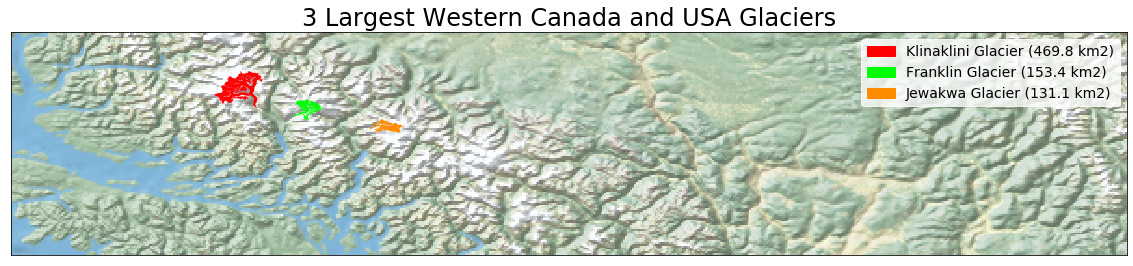

In [13]:
# Plot 3 largest glaciers on natural earth from GLIMS
# Set up legend. Note that the sizes come from an average of GLIMS and RGI. 
# See wgms-glacier-project/data/comparison/compare-glims-rgi.xlsx
legend_colors = ['red', 'lime', 'darkorange']
legend_labels = [glims_glaciers_df['glac_name'][0] + ' (' + str(glims_glaciers_df['area'][0]) + ' km2)',
                 glims_glaciers_df['glac_name'][1] + ' (' + str(glims_glaciers_df['area'][1]) + ' km2)',
                 glims_glaciers_df['glac_name'][2] + ' (' + str(glims_glaciers_df['area'][2]) + ' km2)']
legend_patches = [Patch(color=icolor, label=label)
                  for icolor, label in zip(legend_colors, legend_labels)]

# Set up plot space
fig, ax = plt.subplots(figsize=(20,20))
minx, miny, maxx, maxy = region_outline.total_bounds
miny = 50
maxy = 52
minx = -128
maxx = -118
ax.set_xlim(minx, maxx)
ax.set_ylim(miny, maxy)

# Plot natural earth basemap
ep.plot_rgb(ne_raster,
            rgb=[0, 1, 2],
            extent=ne_src_extent,
            ax=ax)

# Plot 3 largest glaciers from glims dataframe
glims_glaciers_df.iloc[0:1].plot(ax=ax, color='red')
glims_glaciers_df.iloc[1:2].plot(ax=ax, color='lime')
glims_glaciers_df.iloc[2:3].plot(ax=ax, color='darkorange')
ax.set_title('3 Largest ' + region_name + ' Glaciers', fontsize=24)
# Plot legend
ax.legend(handles=legend_patches,
         facecolor ="white",
         edgecolor = "white",
         fontsize = 14,
         bbox_to_anchor = (1.0,1.0))

plt.show()

## Plot RGI Glaciers

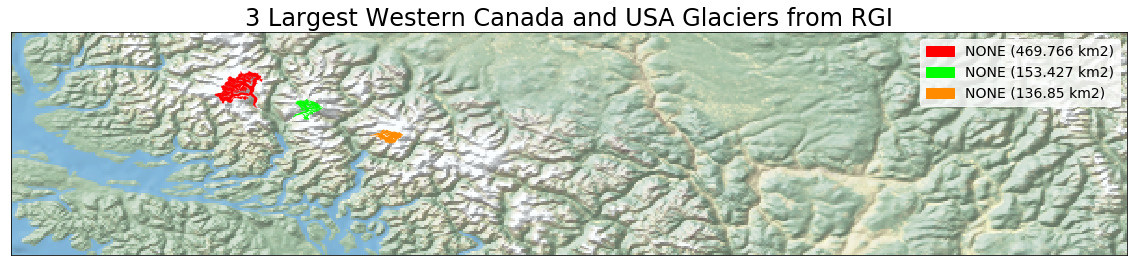

In [14]:
# Plot 3 largest glaciers on natural earth from RGI
legend_colors = ['red', 'lime', 'darkorange']
legend_labels = [rgi_glaciers_df['Name'][0] + ' (' + str(rgi_glaciers_df['Area'][0]) + ' km2)',
                 rgi_glaciers_df['Name'][1] + ' (' + str(rgi_glaciers_df['Area'][1]) + ' km2)',
                 rgi_glaciers_df['Name'][2] + ' (' + str(rgi_glaciers_df['Area'][2]) + ' km2)']
legend_patches = [Patch(color=icolor, label=label)
                  for icolor, label in zip(legend_colors, legend_labels)]

# Set up plot space
fig, ax = plt.subplots(figsize=(20,20))
minx, miny, maxx, maxy = region_outline.total_bounds
miny = 50
maxy = 52
minx = -128
maxx = -118
ax.set_xlim(minx, maxx)
ax.set_ylim(miny, maxy)

# Plot natural earth basemap
ep.plot_rgb(ne_raster,
            rgb=[0, 1, 2],
            extent=ne_src_extent,
            ax=ax)

# Plot 3 largest glaciers from rgi dataframe
rgi_glaciers_df.iloc[0:1].plot(ax=ax, color='red')
rgi_glaciers_df.iloc[1:2].plot(ax=ax, color='lime')
rgi_glaciers_df.iloc[2:3].plot(ax=ax, color='darkorange')
ax.set_title('3 Largest ' + region_name + ' Glaciers from RGI', fontsize=24)
# Plot legend
ax.legend(handles=legend_patches,
         facecolor ="white",
         edgecolor = "white",
         fontsize = 14,
         bbox_to_anchor = (1.0,1.0))

plt.show()

## Compare Glaciers from GLIMS and RGI
Do they match? If yes, continue, if no, stop notebook and investigate

In [15]:
# Comment this code out once investigation is complete
#if (glims_glaciers_df['glac_name'][0] == rgi_glaciers_df['Name'][0] and 
#    glims_glaciers_df['glac_name'][1] == rgi_glaciers_df['Name'][1] and 
#    glims_glaciers_df['glac_name'][2] == rgi_glaciers_df['Name'][2]):
#    print("They match!")
#else:
#    class StopExecution(Exception):
#        def _render_traceback_(self):
#            pass

#    print("They do NOT Match! Stopping notebook.")
#    raise StopExecution

## Create final shapefiles
This section creates and formats the final dataframe, plots it to make sure it looks ok, and saves it to a shapefile.

### Create final dataframe

In [16]:
# Drop columns that are not needed for the final data (use GLIMS dataframe for this)
final_data_df = glims_glaciers_df.drop(['area', 'width', 'length', 
                                        'min_elev', 'mean_elev', 'max_elev'], axis=1)

# Add region_name column
final_data_df['reg_name'] = region_name

# Add primary class (primeclass) column. 
final_data_df['primeclass'] = primeclass

# Rename some columns
final_data_df.rename(columns={'glac_id': 'glims_id', 'db_area': 'area_km2', 
                                       'src_date': 'date'}, inplace=True)

# Drop last 3 rows because they are the fourth and fifth largest glaciers and we aren't interested in them
# Also need to remove the 3rd largest from GLIMS and put in the 3rd largest from RGI since it's bigger
final_data_df.drop([2, 3, 4], inplace = True)

# Add the extra RGI glacier to the final data frame
# Format the RGI date
# This glacier is Heakamie Glacier according to the WGMS FoG browser
rgi_extra_date = rgi_glaciers_df['BgnDate'][2]
rgi_extra_date = '-'.join([rgi_extra_date[:4], rgi_extra_date[4:6], rgi_extra_date[6:]])
final_data_df = final_data_df.append({'region_no' : region_number , 'reg_name' : region_name, 
                                     'glac_name' : 'Heakamie Glacier', 'glims_id' : rgi_glaciers_df['GLIMSId'][2],
                                     'primeclass' : primeclass, 'area_km2' : rgi_glaciers_df['Area'][2],
                                     'date' : rgi_extra_date, 'geometry' : rgi_glaciers_df['geometry'][2]},
                                     ignore_index=True)

# Add RGI ID column
final_data_df['rgi_id'] = (rgi_glaciers_df['RGIId'][0], rgi_glaciers_df['RGIId'][1], rgi_glaciers_df['RGIId'][2])

# Add area_src column that gets filled lower down
final_data_df['area_src'] = '-999'

# Reorder the columns of the dataframe
final_data_df = final_data_df[['region_no', 'reg_name', 'glac_name', 'glims_id', 'rgi_id',
                               'primeclass', 'area_km2', 'area_src', 'date', 'geometry']]

In [17]:
# Swap the 3rd and 4th rows of the RGI dataframe so that the first 3 glaciers in both the RGI and GLIMS dataframes match
#b, c = rgi_glaciers_df.iloc[2].copy(), rgi_glaciers_df.iloc[3].copy()
#rgi_glaciers_df.iloc[2],rgi_glaciers_df.iloc[3] = c,b

In [18]:
final_data_df

,region_no,reg_name,glac_name,glims_id,rgi_id,primeclass,area_km2,area_src,date,geometry
0,2,Western Canada and USA,Klinaklini Glacier,G234082E51540N,RGI60-02.05157,5,469.766,-999,2004-07-22T00:00:00,"POLYGON Z ((-125.771121 51.61014 0, -125.77210..."
1,2,Western Canada and USA,Franklin Glacier,G234658E51318N,RGI60-02.12428,5,153.427,-999,2004-07-22T00:00:00,"POLYGON Z ((-125.228529 51.310758 0, -125.2275..."
2,2,Western Canada and USA,Heakamie Glacier,G235390E51067N,RGI60-02.03578,5,136.850,-999,2004-99-99,"POLYGON ((-124.648724 51.11781500000006, -124...."


In [19]:
# Calculate area and update dataframe as neccessary and clean the date format in the date column
# If GLIMS and RGI dates are the same year, then average the two areas.
# If GLIMS date is more recent, then use that average.
# If RGI date is more recent, then use that average. (Note I don't think this ever happens but sometimes RGI
# has an outline that GLIMS doesn't)
# Note only comparing by year because sometimes the month and day are not known. Year matching is close enough.
for x in range(3):
    # Exract and clean GLIMS date so that it is comparable to RGI date
    glims_date = glims_glaciers_df['src_date'][x][0:10].replace('-', '')
    glims_year = glims_date[0:4]
    print('glims date: ' + glims_date)
    #print('glims year: ' + glims_year)
    
    # Extract RGI date
    rgi_date = rgi_glaciers_df['BgnDate'][x]
    rgi_year = rgi_date[0:4]
    print('rgi date: ' + rgi_date)
    #print('rgi year: ' + rgi_year)
    
    if x == 0 or x == 1:
        if glims_year == rgi_year:
            # Average GLIMS and RGI areas
            area = np.average([glims_glaciers_df['db_area'][x], rgi_glaciers_df['Area'][x]])
            area_src = 'A'
            print('Averaging area: ' + str(area))
        elif glims_year > rgi_year:
            # Use GLIMS area for the area
            area = glims_glaciers_df['db_area'][x]
            area_src = 'G'
            print('Using GLIMS area: ' + str(area))
        elif rgi_year > glims_year:
            # Use RGI area for the area
            area = rgi_glaciers_df['Area'][x]
            area_src = 'R'
            print('Using RGI area: ' + str(area))
        else:
            print("Error. Area could not be calculated.")
    else:
        # The 3rd largest between GLIMS and RGI comes from RGI only, so set the Area of the 3rd largest
        # to the one in RGI
        area = rgi_glaciers_df['Area'][x]
        area_src = 'R'
    
    print('')
    # Set the area in the final dataframe
    final_data_df.iloc[x, final_data_df.columns.get_loc('area_km2')] = area
    final_data_df.iloc[x, final_data_df.columns.get_loc('area_src')] = area_src
    
    # Clean the date format in the final dataframe
    final_data_df.iloc[x, final_data_df.columns.get_loc('date')] = glims_glaciers_df['src_date'][x][0:10]
    
# Set the third largest to the RGI date to RGI since it came from RGI only
final_data_df.iloc[2, final_data_df.columns.get_loc('date')] = rgi_extra_date

glims date: 20040722
rgi date: 20049999
Averaging area: 469.766

glims date: 20040722
rgi date: 20049999
Averaging area: 153.427

glims date: 20040809
rgi date: 20049999



In [20]:
final_data_df

,region_no,reg_name,glac_name,glims_id,rgi_id,primeclass,area_km2,area_src,date,geometry
0,2,Western Canada and USA,Klinaklini Glacier,G234082E51540N,RGI60-02.05157,5,469.766,A,2004-07-22,"POLYGON Z ((-125.771121 51.61014 0, -125.77210..."
1,2,Western Canada and USA,Franklin Glacier,G234658E51318N,RGI60-02.12428,5,153.427,A,2004-07-22,"POLYGON Z ((-125.228529 51.310758 0, -125.2275..."
2,2,Western Canada and USA,Heakamie Glacier,G235390E51067N,RGI60-02.03578,5,136.850,R,2004-99-99,"POLYGON ((-124.648724 51.11781500000006, -124...."


### Plot final dataframe to check accuracy

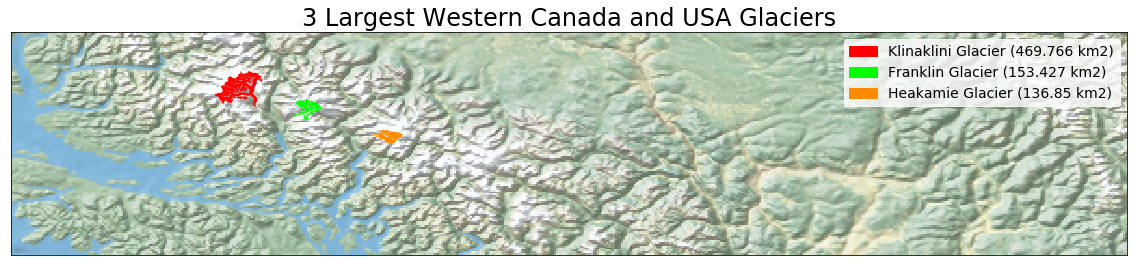

In [21]:
# Check that the geodataframe wasn't corrupted from these changes by plotting the data
# Plot 3 largest glaciers on natural earth from GLIMS
# Set up legend. Note that the sizes come from an average of GLIMS and RGI. 
# See wgms-glacier-project/data/comparison/compare-glims-rgi.xlsx
legend_colors = ['red', 'lime', 'darkorange', 'blue']
legend_labels = [final_data_df['glac_name'][0] + ' (' + str(final_data_df['area_km2'][0]) + ' km2)',
                 final_data_df['glac_name'][1] + ' (' + str(final_data_df['area_km2'][1]) + ' km2)',
                 final_data_df['glac_name'][2] + ' (' + str(final_data_df['area_km2'][2]) + ' km2)']
legend_patches = [Patch(color=icolor, label=label)
                  for icolor, label in zip(legend_colors, legend_labels)]

# Set up plot space
fig, ax = plt.subplots(figsize=(20,20))
minx, miny, maxx, maxy = region_outline.total_bounds
miny = 50
maxy = 52
minx = -128
maxx = -118
ax.set_xlim(minx, maxx)
ax.set_ylim(miny, maxy)

# Plot natural earth basemap
ep.plot_rgb(ne_raster,
            rgb=[0, 1, 2],
            extent=ne_src_extent,
            ax=ax)

# Plot 3 largest glaciers from glims dataframe
final_data_df.iloc[0:1].plot(ax=ax, color='red')
final_data_df.iloc[1:2].plot(ax=ax, color='lime')
final_data_df.iloc[2:3].plot(ax=ax, color='darkorange')
ax.set_title('3 Largest ' + region_name + ' Glaciers', fontsize=24)
# Plot legend
ax.legend(handles=legend_patches,
         facecolor ="white",
         edgecolor = "white",
         fontsize = 14,
         bbox_to_anchor = (1.0,1.0))

plt.show()

### Create shapefile from the final dataframe

In [22]:
# Write dataframe to shapefile and save to zip if it doesn't already exist
zipfile_fn = "data/final-dataset/region-" + region_number + "-largest-glaciers.zip"
if os.path.exists(zipfile_fn) == False:
    # Create the shapefile
    final_data_fn = "data/final-dataset/region-" + region_number + "-largest-glaciers.shp"
    final_data_df.to_file(driver='ESRI Shapefile', filename=final_data_fn)
    
    # Zip up the shapefile
    zipfile_fn = ws.zipshp(final_data_fn, Delete=True)
    print("Creating zipfile: " + zipfile_fn)
else:
    print(zipfile_fn + " already extists")

Creating zipfile: data/final-dataset\region-2-largest-glaciers.zip


## Extra Stuff

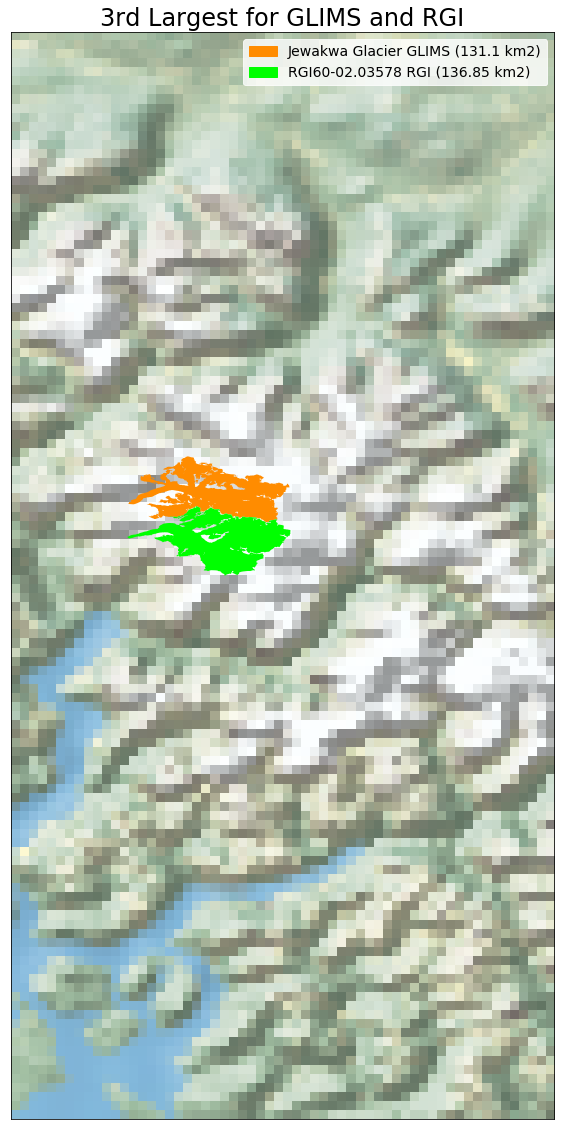

In [23]:
# Plot 3rd largest glacier for GLIMS and RGI. They are different.
legend_colors = ['darkorange', 'lime']
legend_labels = [glims_glaciers_df['glac_name'][2] + ' GLIMS (' + str(glims_glaciers_df['area'][2]) + ' km2)',
                 rgi_glaciers_df['RGIId'][2] + ' RGI (' + str(rgi_glaciers_df['Area'][2]) + ' km2)']
legend_patches = [Patch(color=icolor, label=label)
                  for icolor, label in zip(legend_colors, legend_labels)]

# Set up plot space
fig, ax = plt.subplots(figsize=(20,20))
#minx, miny, maxx, maxy = region_outline.total_bounds
closeup = [-125, 50, -124, 52]
minx, miny, maxx, maxy = closeup
ax.set_xlim(minx, maxx)
ax.set_ylim(miny, maxy)

# Plot natural earth basemap
ep.plot_rgb(ne_raster,
            rgb=[0, 1, 2],
            extent=ne_src_extent,
            ax=ax)

# Plot 3 largest glaciers from glims dataframe
glims_glaciers_df.iloc[2:3].plot(ax=ax, color='darkorange')
rgi_glaciers_df.iloc[2:3].plot(ax=ax, color='lime')
ax.set_title('3rd Largest for GLIMS and RGI', fontsize=24)
# Plot legend
ax.legend(handles=legend_patches,
         facecolor ="white",
         edgecolor = "white",
         fontsize = 14,
         bbox_to_anchor = (1.0,1.0))

plt.show()